In [1]:

import ROOT as rt
import csv
import re
import sys
import collections
import os

from collections import OrderedDict
import uproot
import pandas as pd
import math
import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
sys.path.append('/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/python/')
from helper import make_datacard_2sig, make_datacard_2tag, weight_calc
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
from helper_functions import deltaR, deltaPhi

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0


print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [4]:
fpath =OrderedDict()
tree = OrderedDict()
mass = [15, 40, 55]


data_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/Run3/V1p19/Data2022/v3/normalized/'#fixed timeweighted


fpath['data'] = data_path + 'DisplacedJet-EXOCSCCluster_Run2022EFG-PromptReco-v1_goodLumi.root'
# mc_path = {}


fpath['signal'] = '/storage/cms/store/user/christiw/displacedJetMuonAnalyzer/Run3/V1p19/MC_Summer22EE/v1/sixie/v3/normalized/ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_13p6TeV_1pb_weighted.root'
lumi = 23.02*1000
NEvents = {}
for k,v in fpath.items():
    root_dir = uproot.open(v) 
    if not root_dir: 
        print(k, "zombie")
        continue
    tree[k] = root_dir['MuonSystem']
#     NEvents[k] = root_dir['NEvents'][1]
    NEvents[k] = root_dir['NEvents']._fEntries
    print(k)
#     if not 'data' in k: 
#         print(k, root_dir['NEvents']._fEntries)


root_dir = uproot.open('/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/data/HiggsPtWeights/ZHToggZH_HiggsPtReweight.root') 
h_reweight = root_dir['higgsPthiggsEta']

data
signal


# Selections

In [27]:

jetPt_cut = 50

weight = {}
nhits1 = {}
nhits2 = {}
sel_ev = {}
cond = {}
cscClusterTime = {}
cluster_index = ''
dtRechitClusterMuonVetoPt = {}
dtRechitClusterAvgStation = {}
dtRechitClusterMaxStation = {}
dtRechitCluster_match_RPCBx_dPhi0p5 = {}
cscRechitClusterMuonVetoPt = {}
cscRechitClusterAvgStation = {}
cscRechitClusterTimeWeighted = {}
cscRechitClusterEta = {}
cscRechitClusterMe11Ratio = {}
nCluster = {}
nTrgCluster = {}
met = {}
# 0: 2 CSC; 1: 2DT; 2: csc+dt
category = 2


for k in list(tree.keys()):
#     if not 'ggH' in k:continue
#     if  not 'data' in k:continue
########### SELECTION: CLUSTERS ############
    if 'data' in k: T = tree['data']
    else: T = tree[k]
    sel_csccluster = T.array('cscRechitClusterSize') >= 0

    sel_trgCluster = np.logical_and( T.array('cscRechitClusterSize') >= 100, np.logical_and(T.array('cscRechitClusterNStation10')>=2, np.abs(T.array('cscRechitClusterEta'))<1.9))
    sel_trgCluster =np.logical_or(sel_trgCluster, np.logical_and( T.array('cscRechitClusterSize') >= 200, np.logical_and(T.array('cscRechitClusterNStation10')==1, np.abs(T.array('cscRechitClusterEta'))<1.9)))
    sel_trgCluster =np.logical_or(sel_trgCluster, np.logical_and( T.array('cscRechitClusterSize') >= 500, np.abs(T.array('cscRechitClusterEta'))>=1.9))
#     sel_trgCluster = np.logical_and( T.array('cscRechitClusterSize') >= 100, np.logical_and(T.array('cscRechitClusterNStation')>=2, np.abs(T.array('cscRechitClusterEta'))<1.9))
#     sel_trgCluster =np.logical_or(sel_trgCluster, np.logical_and( T.array('cscRechitClusterSize') >= 200, np.logical_and(T.array('cscRechitClusterNStation')==1, np.abs(T.array('cscRechitClusterEta'))<1.9)))
#     sel_trgCluster =np.logical_or(sel_trgCluster, np.logical_and( T.array('cscRechitClusterSize') >= 500, np.abs(T.array('cscRechitClusterEta'))>=1.9))
    
    sel_dtcluster = np.abs(T.array('dtRechitClusterSize')) > 50
#     sel_dtcluster = np.logical_and(sel_dtcluster,np.abs(T.array('dtRechitCluster_match_RPChits_dPhi0p5')) > 0)
#     sel_dtcluster = np.logical_and(sel_dtcluster,np.abs(T.array('dtRechitCluster_match_RPCBx_dPhi0p5')) == 0)
#     sel_dtcluster = np.logical_and(sel_dtcluster,np.abs(T.array('dtRechitClusterMuonVetoPt')) < 10)




########### SELECTION: JETS ############
    
    sel_jet = np.logical_and(T.array('jetPt') > 30, np.abs(T.array('jetEta')) < 2.4 )
    sel_jet = np.logical_and(T.array('jetTightPassId'), sel_jet)


#     564  HLT_L1MET_DTCluster50
# 565  HLT_L1MET_DTClusterNoMB1S50
# 566  HLT_CscCluster_Loose
# 567  HLT_CscCluster_Medium
# 568  HLT_CscCluster_Tight
# 569  HLT_L1CSCShower_DTCluster50
# 570  HLT_L1CSCShower_DTCluster75
    
########### SELECTION: EVENTS ############

#     sel_ev[k] = np.logical_or(T.array('HLTDecision')[:,566], T.array('HLTDecision')[:,569])
    sel_ev[k] = T.array('HLTDecision')[:,569]
#     sel_ev[k] = T.array('HLTDecision')[:,566]


    if k == 'data': sel_ev[k] = np.logical_and(sel_ev[k], T.array('runNum')>=360019)
#     else: sel_ev[k] = np.logical_and(sel_ev[k], T.array('')
########### BRANCHES ############
                            
    
    sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum()== 1)
    sel_ev[k]  = np.logical_and(sel_ev[k],sel_dtcluster.sum()>= 1)
#             cond[k] = deltaR(T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][sel_ev[k]][:,0], T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_csccluster][sel_ev[k]][:,0],\
#                             T.array('dtRechitCluster' + cluster_index + 'Eta')[sel_dtcluster][sel_ev[k]][:,0], T.array('dtRechitCluster' + cluster_index + 'Phi')[sel_dtcluster][sel_ev[k]][:,0])<2.5
    nhits1[k] =  T.array('dtRechitClusterSize')[sel_dtcluster][sel_ev[k]]
    nCluster[k] = sel_trgCluster.count()[sel_ev[k]]
    nTrgCluster[k] = sel_trgCluster.sum()[sel_ev[k]]
    nhits2[k] =  T.array('cscRechitClusterSize')[sel_csccluster][sel_ev[k]]
    

    dtRechitClusterMuonVetoPt[k] = T.array('dtRechitClusterMuonVetoPt')[sel_dtcluster][sel_ev[k]]
    dtRechitClusterAvgStation[k] = T.array('dtRechitClusterAvgStation10')[sel_dtcluster][sel_ev[k]]
    dtRechitClusterMaxStation[k] = T.array('dtRechitClusterMaxStation')[sel_dtcluster][sel_ev[k]]
    dtRechitCluster_match_RPCBx_dPhi0p5[k] = T.array('dtRechitCluster_match_RPCBx_dPhi0p5')[sel_dtcluster][sel_ev[k]]

    cscRechitClusterMuonVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt')[sel_csccluster][sel_ev[k]]

#     cscRechitClusterJetVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')[sel_csccluster][sel_ev[k]]

    cscRechitClusterAvgStation[k] = T.array('cscRechitCluster' + cluster_index + 'AvgStation10')[sel_csccluster][sel_ev[k]]
    cscRechitClusterTimeWeighted[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')[sel_csccluster][sel_ev[k]]
    cscRechitClusterEta[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][sel_ev[k]]
#     cscRechitClusterMe11Ratio[k] =  T.array('cscRechitCluster' + cluster_index + 'Me11Ratio')[sel_csccluster][sel_ev[k]]


    met[k] = T.array('met')[sel_ev[k]]
    weight[k] = T.array('weight')[sel_ev[k]]
    if k == 'signal': weight[k] *= lumi

data 0.6075644150136096
data 308871.0
signal 0.6908319498247556
signal 5421.0


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


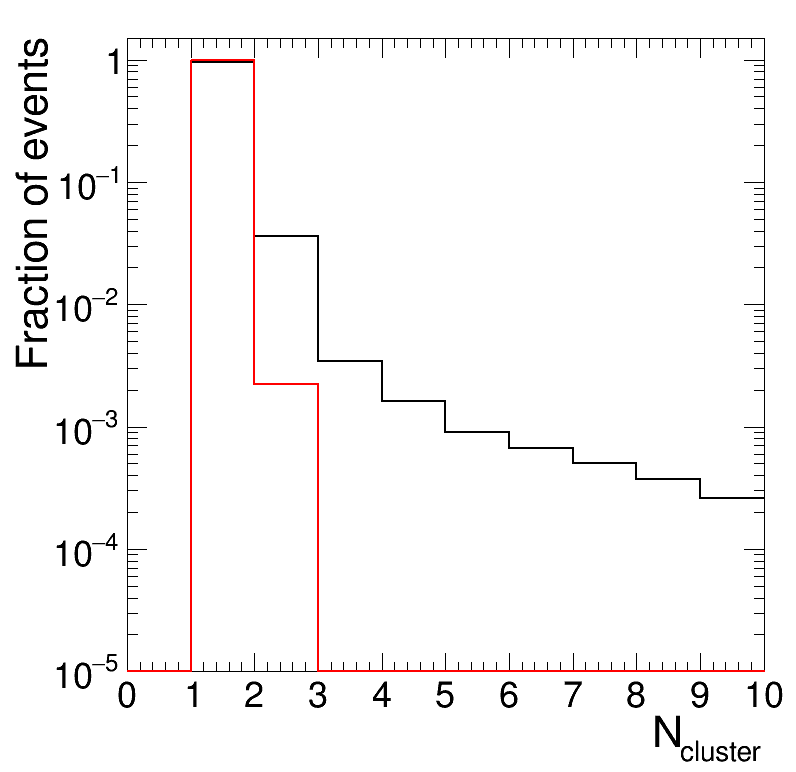

In [31]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.7,0.7,0.9,0.92)


leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h = {}

for i, k in enumerate(weight.keys()):
#     h[k] = create_TH1D(cscRechitClusterEta[k].count(), axis_title = ['number of CSC clusters', 'Fraction of events'], weights = weight[k], binning = [5,0,5])
#     h[k] = create_TH1D(np.abs(cscRechitClusterEta[k][cscRechitClusterEta[k].count()==1]), axis_title = ['cluster #eta', 'Fraction of events'],  binning = [50,0.7,3])

    h[k] = create_TH1D(cscRechitClusterTimeWeighted[k], axis_title = ['cluster time [ns]', 'Fraction of events'],  binning = [50,-100,100])
    
#     h[k] = create_TH1D(cscRechitClusterTimeWeighted[k][cscRechitClusterTimeWeighted[k].count()==1], axis_title = ['cluster time [ns]', 'Fraction of events'],  binning = [50,-100,100])

#     h[k] = create_TH1D(nTrgCluster[k], axis_title = ['N_{cluster}', 'Fraction of events'],  binning = [10,0,10])

#     h[k] = create_TH1D(nCluster[k], axis_title = ['N_{cluster}', 'Fraction of events'],  binning = [10,0,10])

    h[k] = create_TH1D(dtRechitCluster_match_RPCBx_dPhi0p5[k].count(), axis_title = ['N_{cluster}', 'Fraction of events'],  binning = [10,0,10])

    
#     h[k] = create_TH1D(np.abs(cscRechitClusterAvgStation[k][:,0]), axis_title = ['cluster average station', 'Fraction of events'], weights = weight[k], binning = [50,0,5])

#     h[k] = create_TH1D(np.abs(cscRechitClusterMuonVetoPt[k][:,0]), axis_title = ['cscRechitClusterMuonVetoPt', 'Fraction of events'], weights = weight[k], binning = [50,0,100])

#     h[k] = create_TH1D(met[k], axis_title = ['MET [GeV]', 'Fraction of events'], weights = weight[k], binning = [50,0,500])

#     h[k] = create_TH1D(dtRechitCluster_match_RPCBx_dPhi0p5[k][:,0], axis_title = ['cluster BX', 'Fraction of events'],  binning = [10,-5,5])
#     h[k] = create_TH1D(dtRechitClusterMuonVetoPt[k][:,0], axis_title = ['cluster BX', 'Fraction of events'],  weights = weight[k],binning = [50,0,500])


    print(k, np.count_nonzero(met[k]>30)/len(met[k]))
    
    print(k, h[k].Integral())


    h[k].Scale(1./h[k].Integral())

    h[k].SetMaximum(1.5)
    h[k].SetMinimum(1e-5)
    h[k].SetLineColor(std_color_list[i])
    if k == 'data':leg.AddEntry(h[k],k)
    else: leg.AddEntry(h[k], k)
    h[k].Draw('hist same')
# leg.Draw()
c.SetRightMargin(0.04)



c.SetLogy()
c.Draw()
